<a href="https://www.kaggle.com/code/iasonasxrist/mri-brain-tumour-segmentation-with-unet-cnn?scriptVersionId=107332844" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Image Segmentation using UNet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Import Libraries

In [2]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from glob import glob
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [3]:
DataPath = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'


dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [4]:
print(masks[:10], images[:10])

['TCGA_DU_7010_19860307_56_mask.tif', 'TCGA_DU_7010_19860307_8_mask.tif', 'TCGA_DU_7010_19860307_34_mask.tif', 'TCGA_DU_7010_19860307_33_mask.tif', 'TCGA_DU_7010_19860307_43_mask.tif', 'TCGA_DU_7010_19860307_39_mask.tif', 'TCGA_DU_7010_19860307_7_mask.tif', 'TCGA_DU_7010_19860307_31_mask.tif', 'TCGA_DU_7010_19860307_6_mask.tif', 'TCGA_DU_7010_19860307_38_mask.tif'] ['TCGA_DU_7010_19860307_56.tif', 'TCGA_DU_7010_19860307_8.tif', 'TCGA_DU_7010_19860307_34.tif', 'TCGA_DU_7010_19860307_33.tif', 'TCGA_DU_7010_19860307_43.tif', 'TCGA_DU_7010_19860307_39.tif', 'TCGA_DU_7010_19860307_7.tif', 'TCGA_DU_7010_19860307_31.tif', 'TCGA_DU_7010_19860307_6.tif', 'TCGA_DU_7010_19860307_38.tif']


In [5]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [6]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images':images,'masks':masks})

In [7]:
imagePath_df.head(9)

,directory,images,masks
0,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif
1,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif
2,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif
3,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif
4,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif
5,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_39.tif,TCGA_DU_7010_19860307_39_mask.tif
6,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_7.tif,TCGA_DU_7010_19860307_7_mask.tif
7,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_31.tif,TCGA_DU_7010_19860307_31_mask.tif
8,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_6.tif,TCGA_DU_7010_19860307_6_mask.tif


## Image Shape

In [8]:
def print_imShape():
    idx = random.randint(0,len(dirs))
    
    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape)
    print(mask.shape)

In [9]:
for i in range(5):
    print_imShape()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


## Plot Images

In [10]:
def plot_images():
    
    idx = random.randint(0,len(imagePath_df))
    
    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title("Brain MRI Slice")
    
    plt.grid(False)
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    plt.grid(False)
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

    
    
    


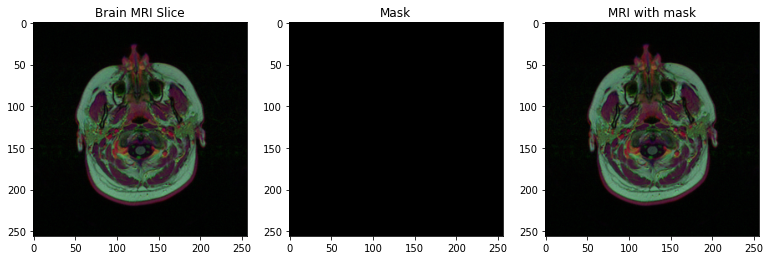

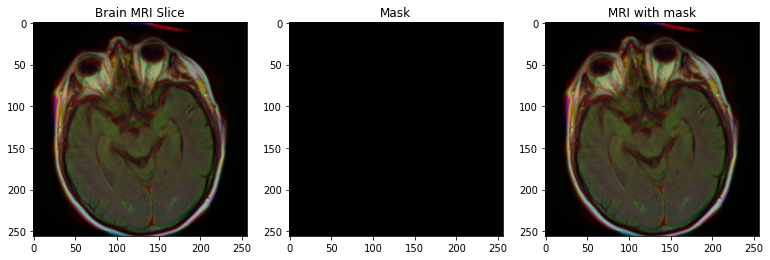

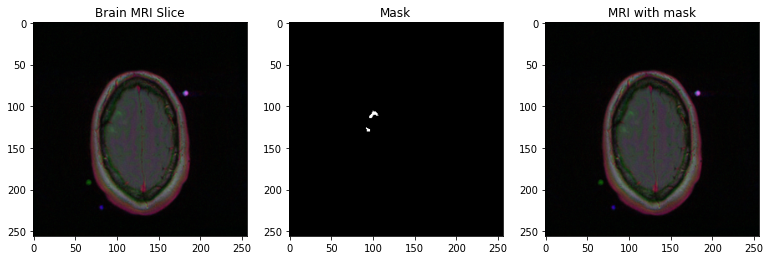

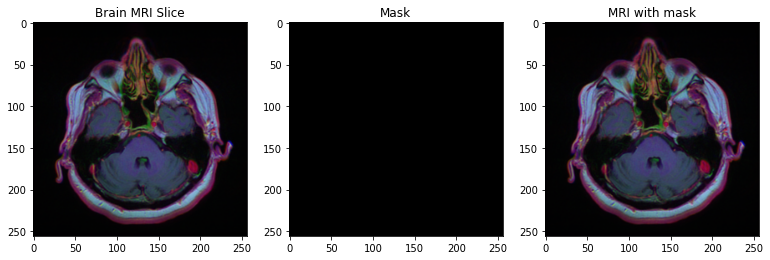

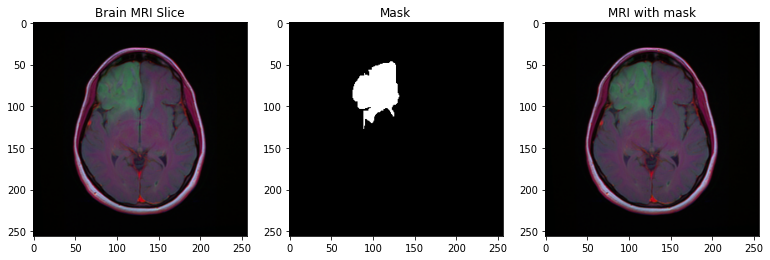

In [11]:
for i in range(5):
    plot_images()

## Config

In [12]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 


In [13]:
train_files = []
mask_files = glob("../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*")

for f in tqdm(mask_files):
    train_files.append(f.replace('_mask', ''))
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

100%|██████████| 3929/3929 [00:00<00:00, 1494054.43it/s]


In [14]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.15, shuffle = True)
df_train, df_test = train_test_split(df_train, test_size=0.25, shuffle = True)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2504, 2)
(590, 2)
(835, 2)


## Play with Epochs , Batch_size later


In [15]:
EPOCHS = 35
BATCH_SIZE = 32
ImgHeight = 256
ImgWidth = 256
Channels = 3

In [16]:
def adjust(img,mask):
    #normalization
    img = img / 255.

    #mask
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

## Data Generator¶


In [17]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [18]:
def train_generator(dataframe, batch_size, aug_dict, 
                    image_color_mode = "rgb",
                    mask_color_mode = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix = "mask",
                    save_to_dir = None,
                    target_size = (256,256),
                    seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

  #image
    image_generator = image_datagen.flow_from_dataframe(
          dataframe,
          x_col = "image_path",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = image_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = image_save_prefix,
          seed = seed )

      #mask
    mask_generator = mask_datagen.flow_from_dataframe(
          dataframe,
          x_col = "mask_path",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = mask_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = mask_save_prefix,
          seed = seed)
  
  #combining the generators to make a whole generator
    train_gen = zip(image_generator, mask_generator)

  #data adjustment
    for (img, mask) in train_gen:
        img, mask = adjust(img, mask)
        yield (img,mask)
    

## Validation

In [19]:
# # image generator
# imagegen = ImageDataGenerator(rescale=1./255.)
# maskgen = ImageDataGenerator(rescale=1./255.)

# #train generator
# vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
#                                              x_col = "image-path",
#                                              batch_size = BATCH_SIZE,
#                                              seed=42,
#                                              class_mode=None,
#                                              target_size = (ImgHeight,ImgWidth),
#                                              color_mode='rgb')
# # validation data generator
# vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
#                                              x_col = "mask-path",
#                                              batch_size = BATCH_SIZE,
#                                              seed=42,
#                                              class_mode=None,
#                                              target_size = (ImgHeight,ImgWidth),
#                                              color_mode='grayscale')

In [20]:
IMG_SIZE = (256,256)
train_gen = train_generator(df_train, batch_size= BATCH_SIZE, 
                            aug_dict = data_augmentation,
                            target_size = IMG_SIZE)
test_gen = train_generator(df_val, batch_size = BATCH_SIZE,
                           aug_dict = dict(),
                           target_size = IMG_SIZE)

## UNet
UNet is a fully convolutional neural-network. It got its name due to its U-shaped network architecture. It is currently SOTA in the sementic segmentation.

What is semenctic segmentation?

Well its a type of problem studied in computer vision just like image classification, object detection etc.

Image Classification: We Iddentify what is present in an image. If it is present or not

Object Detection: We identify what is present in the image and where it is present. Its sometimes also called object localization.

Image Segentation: In object detection we identify position of an object by labeling a bounding box. In image segmentation we assign each pixel belongs to an image or not. There are two types of Image segmentation: Sementic segmentation and Instance segmentation.following image might help a little bit to visualize difference between these two

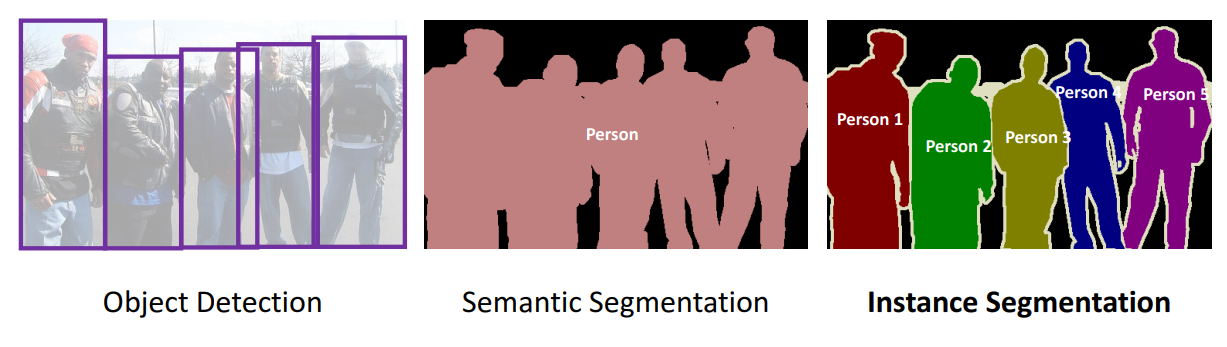

## Key aspects of UNet:

Convolution Layers: Convolution operation are used learn information from images which then can be used as features for mcahine learning problems

Down Sampling: Sequence of convolution combined with max pooling results in down sampling. In down sampling Size of image is reduced which means we can observe larger portion of image in a single convolution operation. Down sampling is a good approach for identifying what is present in the image. but for identifying where the object is we need to use upsampling.

Up Sampling: It is just opposite of down sampling. We go from low resolution to high resolution. For up sampling UNet uses transposed covolution which is achieved by taking transpose of filter kernels and reversing the process of convolution. If you want to learn more please check out this and this.
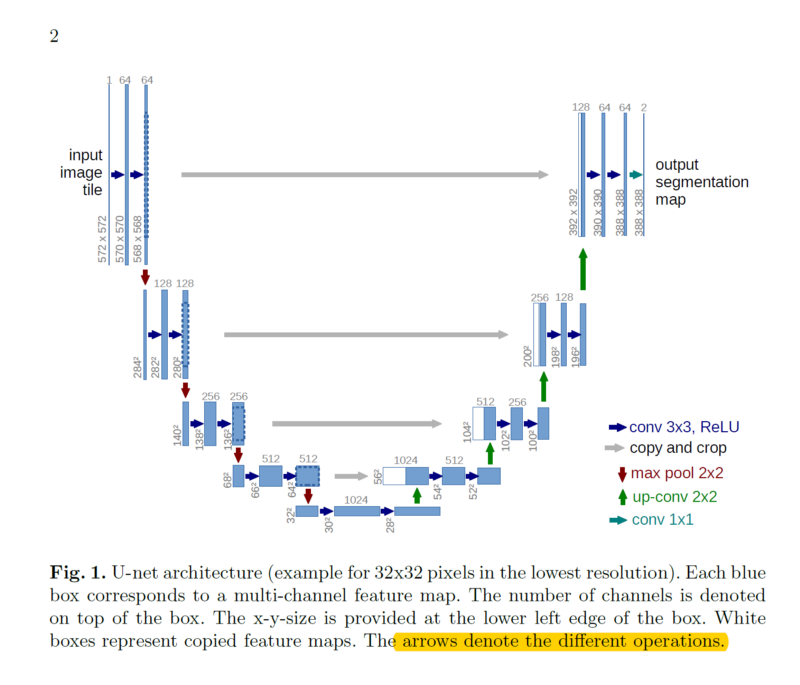
Finally we come to UNet Architecture

Following picture gives a clear picture of What a UNet is. Since there are only convolution layers in this network, therefore its a FCN.

In [21]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [22]:
def UNET(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [23]:

def iou(ytrue, ypred):
    smoothing_factor= 0.0000001
    #    0.0000001
    
    #y_true_f=K.flatten(y_true)
    #y_pred_f=K.flatten(y_pred)
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    return -iou(y_true, y_pred)

# Dice Sorenson
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
#     0.0000001
#     ytrue_f = K.flatten(ytrue)
#     ypred_f = K.flatten(ypred)

    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [24]:
EPOCHS = 150
learning_rate = 0.05
decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, epsilon= 0.1, decay=decay_rate, amsgrad=False)

In [25]:
input_img = Input((ImgHeight,ImgWidth,3), name='img')
model = UNET(input_img, n_filters=64, dropout=0.2, batchnorm=True)
# model.compile(optimizer=Adam(), loss = "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.MeanIoU(num_classes=2)])
"""Θα χρησιμοποιήσουμε αυτό σε μεταγενέστερο training """
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])

# tf.keras.metrics.Precision()
# tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

2022-10-06 10:14:38.981123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 10:14:39.073206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 10:14:39.073989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 10:14:39.075161: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

## Callbacks

In [27]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=10, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-brain-mri-v9.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [28]:
results = model.fit(train_gen,
          steps_per_epoch = len(df_train)/BATCH_SIZE,
          epochs = EPOCHS,
          callbacks = callbacks,
          validation_data = test_gen,
          validation_steps= len(df_val)/ BATCH_SIZE) 

Found 2504 validated image filenames.
Found 2504 validated image filenames.


2022-10-06 10:14:46.037123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-10-06 10:14:49.127609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/78 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9522 - iou: 0.0443 - dice_coef: 0.0831 - precision: 0.0311Found 590 validated image filenames.
Found 590 validated image filenames.
78/78 [==============================] - 113s 1s/step - loss: 0.1427 - accuracy: 0.9522 - iou: 0.0443 - dice_coef: 0.0831 - precision: 0.0311 - val_loss: 0.1377 - val_accuracy: 0.9894 - val_iou: 0.0189 - val_dice_coef: 0.0370 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.13767, saving model to model-brain-mri-v9.h5
Epoch 2/150
78/78 [==============================] - 73s 935ms/step - loss: 0.0377 - accuracy: 0.9899 - iou: 0.0945 - dice_coef: 0.1704 - precision: 0.5573 - val_loss: 0.0557 - val_accuracy: 0.9896 - val_iou: 0.0327 - val_dice_coef: 0.0631 - val_precision: 0.7662

Epoch 00002: val_loss improved from 0.13767 to 0.05569, saving model to model-brain-mri-v9.h5
Epoch 3/150
78/78 [==============================] - 72s 920ms/step - loss: 0.0548 - a

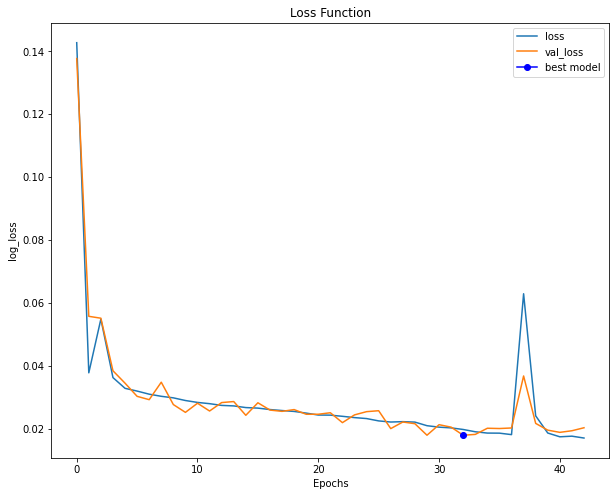

In [29]:
plt.figure(figsize=[10,8])
plt.title("Loss Function")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")

plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="o", color="b", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()



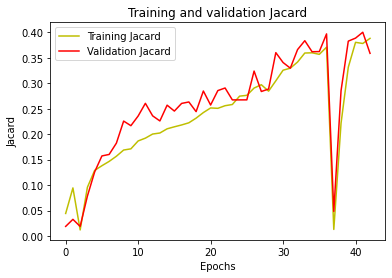

In [30]:
plt.title("Loss Function")

plt.title('Training and validation Jacard')
plt.plot(results.history["iou"], 'y', label='Training Jacard')
plt.plot(results.history['val_iou'], 'r', label='Validation Jacard')

plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

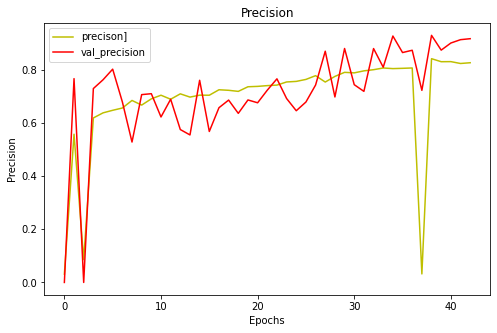

In [31]:
plt.figure(figsize=[8,5])
plt.title("Precision")
plt.plot(results.history["precision"],'y', label = "precison]")
plt.plot(results.history["val_precision"], 'r', label='val_precision')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
# plt.grid(False)
plt.show()

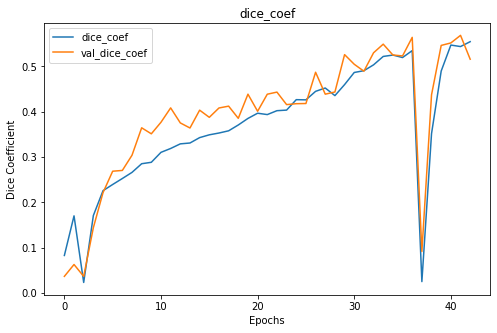

In [32]:
plt.figure(figsize=[8,5])
plt.title("dice_coef")
plt.plot(results.history["dice_coef"], label = "dice_coef")
plt.plot(results.history["val_dice_coef"], label = "val_dice_coef")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
# plt.grid(False)
plt.show()

## Prediction

In [33]:
model.load_weights('model-brain-mri-v9.h5')
# model =models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})


In [34]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)
"accuracy", iou, dice_coef,tf.keras.metrics.Precision()

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
# print("Test Accuracy: ",results[1])
print("Test IoU: ",results[2])
print("Test Dice Coefficient: ",results[3])
print("Test Precision: ",results[4])

Found 835 validated image filenames.
Found 835 validated image filenames.
26/26 [==============================] - 12s 454ms/step - loss: 0.0189 - accuracy: 0.9941 - iou: 0.3364 - dice_coef: 0.4939 - precision: 0.8343
Test loss:  0.018867092207074165
Test IoU:  0.3363882005214691
Test Dice Coefficient:  0.493948757648468
Test Precision:  0.8343321681022644


## Prediction Visualization

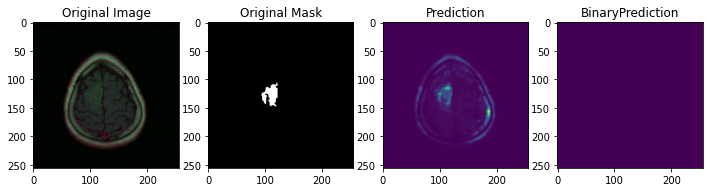

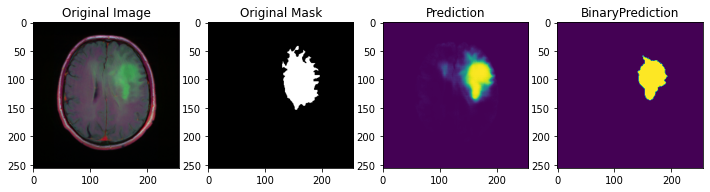

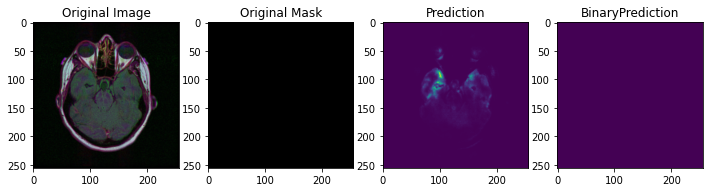

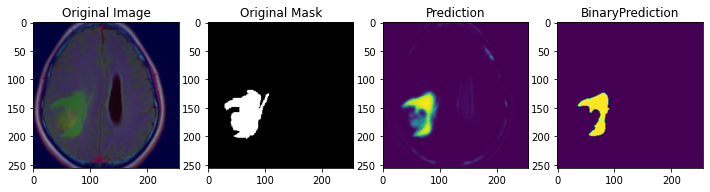

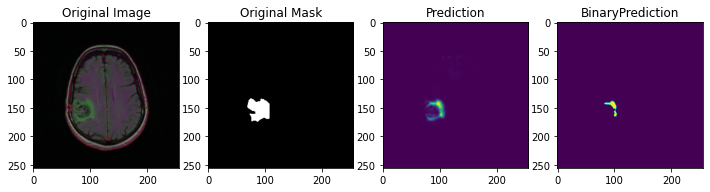

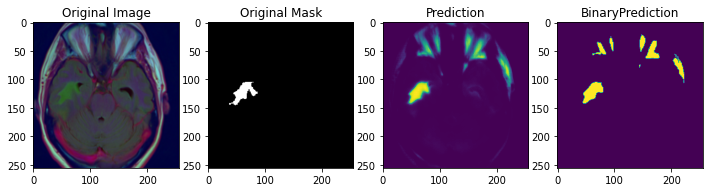

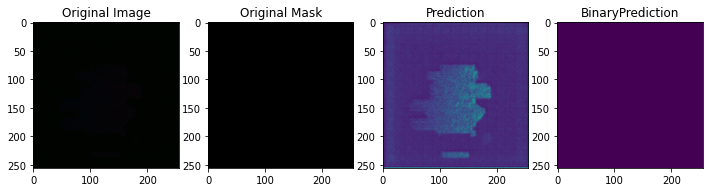

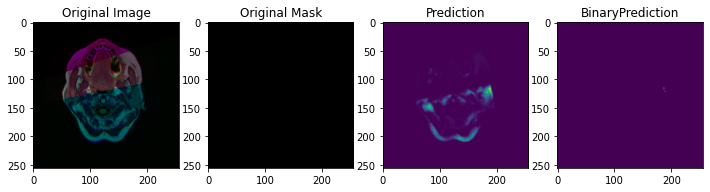

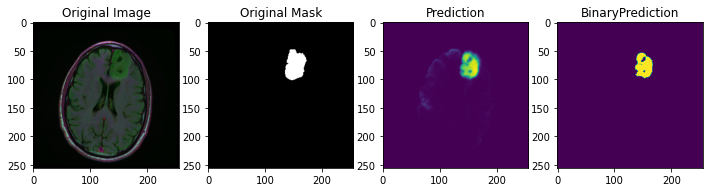

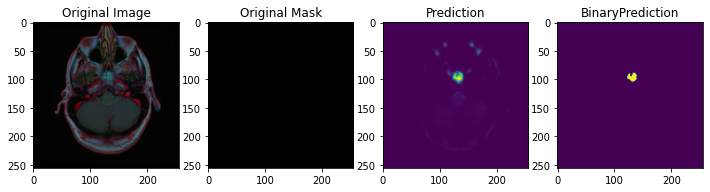

In [35]:
for i in range(10):
    idx = random.randint(0,len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
    pred=model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

In [36]:

#%%
# """8"""
# y_pred=model.predict(x_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)
# y_test_argmax=np.argmax(y_test, axis=3)

# test_jacard = jacard(y_test,y_pred)
# print(test_jacard)
# #%%
# """9"""
# fig, ax = plt.subplots(5, 3, figsize = (12,18)) 
# for i in range(0,5):
#     test_img_number = random.randint(0, len(x_test))
#     test_img = x_test[test_img_number]
#     ground_truth=y_test_argmax[test_img_number] 
#     test_img_input=np.expand_dims(test_img, 0) 
#     prediction = (model.predict(test_img_input)) 
#     predicted_img=np.argmax(prediction, axis=3)[0,:,:]    
    
#     ax[i,0].imshow(test_img)
#     ax[i,0].set_title("RGB Image",fontsize=16)
#     ax[i,1].imshow(ground_truth)
#     ax[i,1].set_title("Ground Truth",fontsize=16)
#     ax[i,2].imshow(predicted_img)
#     ax[i,2].set_title("Prediction",fontsize=16)
#     i+=i
    
# plt.show()